# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    #Resize Images and convert them to tensor
    transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()])
    #Initialize dataloader
    image_data = datasets.ImageFolder(data_dir,transform)
    data_loader = torch.utils.data.DataLoader(image_data, batch_size,shuffle=True,num_workers=1)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

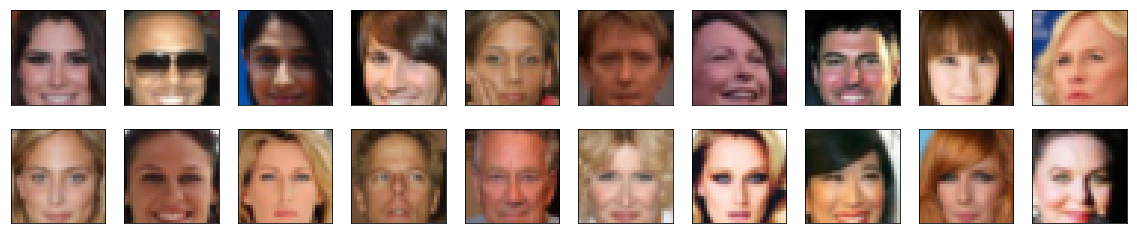

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x*(feature_range[1]-feature_range[0])+feature_range[0]
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9137)
Max:  tensor(0.6706)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        # cascade of convolutional layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # final, fully-connected layer output layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)   
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64 
z_size = 125

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=125, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            ##
            #Train Discriminator
            ##
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            d_real_loss = real_loss(D(real_images))

            # 2. Train the generator with an adversarial loss
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
                
            D_fake = D(G(z))
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss+d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            ##
            #Train Generator
            ##
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.5814 | g_loss: 1.3689
Epoch [    1/   50] | d_loss: 0.1897 | g_loss: 5.6061
Epoch [    1/   50] | d_loss: 0.4472 | g_loss: 3.0670
Epoch [    1/   50] | d_loss: 0.2655 | g_loss: 3.6735
Epoch [    1/   50] | d_loss: 0.4594 | g_loss: 3.9696
Epoch [    1/   50] | d_loss: 0.3411 | g_loss: 3.8077
Epoch [    1/   50] | d_loss: 0.2495 | g_loss: 3.7937
Epoch [    1/   50] | d_loss: 0.4252 | g_loss: 4.0137
Epoch [    1/   50] | d_loss: 1.0426 | g_loss: 3.2254
Epoch [    1/   50] | d_loss: 1.4416 | g_loss: 1.2988
Epoch [    1/   50] | d_loss: 0.8341 | g_loss: 1.4237
Epoch [    1/   50] | d_loss: 0.5398 | g_loss: 4.0697
Epoch [    1/   50] | d_loss: 1.1078 | g_loss: 3.2973
Epoch [    1/   50] | d_loss: 0.5963 | g_loss: 2.5992
Epoch [    1/   50] | d_loss: 0.5679 | g_loss: 2.5790
Epoch [    1/   50] | d_loss: 0.6004 | g_loss: 3.7925
Epoch [    1/   50] | d_loss: 0.8244 | g_loss: 2.0141
Epoch [    1/   50] | d_loss: 0.9256 | g_loss: 1.0633
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.7024 | g_loss: 2.3632
Epoch [    3/   50] | d_loss: 1.1222 | g_loss: 2.3278
Epoch [    3/   50] | d_loss: 0.8228 | g_loss: 1.6868
Epoch [    3/   50] | d_loss: 1.4122 | g_loss: 1.3737
Epoch [    3/   50] | d_loss: 1.0434 | g_loss: 2.0745
Epoch [    3/   50] | d_loss: 1.0303 | g_loss: 1.4531
Epoch [    3/   50] | d_loss: 0.8617 | g_loss: 2.6898
Epoch [    3/   50] | d_loss: 1.0719 | g_loss: 1.7165
Epoch [    3/   50] | d_loss: 0.7761 | g_loss: 1.2339
Epoch [    3/   50] | d_loss: 0.8128 | g_loss: 1.8461
Epoch [    3/   50] | d_loss: 0.8500 | g_loss: 1.7270
Epoch [    3/   50] | d_loss: 0.8708 | g_loss: 1.8657
Epoch [    3/   50] | d_loss: 0.8051 | g_loss: 2.5036
Epoch [    3/   50] | d_loss: 0.6851 | g_loss: 1.9647
Epoch [    3/   50] | d_loss: 1.4852 | g_loss: 1.7407
Epoch [    3/   50] | d_loss: 0.9502 | g_loss: 2.0123
Epoch [    3/   50] | d_loss: 0.9851 | g_loss: 1.6176
Epoch [    3/   50] | d_loss: 1.8403 | g_loss: 0.5968
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.4525 | g_loss: 1.7873
Epoch [    6/   50] | d_loss: 0.6696 | g_loss: 3.0135
Epoch [    6/   50] | d_loss: 1.1406 | g_loss: 2.8386
Epoch [    6/   50] | d_loss: 0.6494 | g_loss: 1.9142
Epoch [    6/   50] | d_loss: 0.7493 | g_loss: 1.9406
Epoch [    6/   50] | d_loss: 0.9421 | g_loss: 1.1582
Epoch [    6/   50] | d_loss: 0.6950 | g_loss: 1.4823
Epoch [    6/   50] | d_loss: 0.6761 | g_loss: 1.3905
Epoch [    6/   50] | d_loss: 0.5409 | g_loss: 1.1235
Epoch [    6/   50] | d_loss: 0.8650 | g_loss: 2.6373
Epoch [    6/   50] | d_loss: 0.7150 | g_loss: 1.6493
Epoch [    6/   50] | d_loss: 0.4857 | g_loss: 3.0482
Epoch [    6/   50] | d_loss: 0.7032 | g_loss: 1.9882
Epoch [    6/   50] | d_loss: 1.0431 | g_loss: 3.0849
Epoch [    6/   50] | d_loss: 0.6118 | g_loss: 1.9558
Epoch [    6/   50] | d_loss: 1.1062 | g_loss: 2.3128
Epoch [    6/   50] | d_loss: 0.5006 | g_loss: 1.3459
Epoch [    6/   50] | d_loss: 0.7061 | g_loss: 3.6114
Epoch [    6/   50] | d_loss

Epoch [    9/   50] | d_loss: 0.5525 | g_loss: 2.6460
Epoch [    9/   50] | d_loss: 0.2867 | g_loss: 3.6535
Epoch [    9/   50] | d_loss: 0.5935 | g_loss: 2.6584
Epoch [    9/   50] | d_loss: 0.4646 | g_loss: 2.6168
Epoch [    9/   50] | d_loss: 0.8806 | g_loss: 2.7401
Epoch [    9/   50] | d_loss: 0.2621 | g_loss: 1.9544
Epoch [    9/   50] | d_loss: 0.4144 | g_loss: 3.0465
Epoch [    9/   50] | d_loss: 0.3288 | g_loss: 2.5539
Epoch [    9/   50] | d_loss: 0.4147 | g_loss: 2.0823
Epoch [    9/   50] | d_loss: 0.6191 | g_loss: 1.6262
Epoch [    9/   50] | d_loss: 0.7647 | g_loss: 2.2056
Epoch [    9/   50] | d_loss: 0.4696 | g_loss: 1.3138
Epoch [    9/   50] | d_loss: 0.4112 | g_loss: 2.6334
Epoch [    9/   50] | d_loss: 0.2663 | g_loss: 3.0728
Epoch [    9/   50] | d_loss: 0.3941 | g_loss: 2.3310
Epoch [    9/   50] | d_loss: 0.5643 | g_loss: 1.7543
Epoch [    9/   50] | d_loss: 0.6703 | g_loss: 1.7239
Epoch [    9/   50] | d_loss: 0.8142 | g_loss: 1.4714
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.2265 | g_loss: 2.3127
Epoch [   11/   50] | d_loss: 0.5560 | g_loss: 2.5579
Epoch [   11/   50] | d_loss: 0.4405 | g_loss: 3.1160
Epoch [   11/   50] | d_loss: 0.9536 | g_loss: 1.8102
Epoch [   11/   50] | d_loss: 0.1314 | g_loss: 5.3959
Epoch [   11/   50] | d_loss: 0.6308 | g_loss: 1.7259
Epoch [   11/   50] | d_loss: 1.0210 | g_loss: 2.5871
Epoch [   11/   50] | d_loss: 0.3522 | g_loss: 4.7279
Epoch [   11/   50] | d_loss: 0.7999 | g_loss: 0.3836
Epoch [   11/   50] | d_loss: 0.4023 | g_loss: 1.7753
Epoch [   11/   50] | d_loss: 0.4407 | g_loss: 2.2251
Epoch [   11/   50] | d_loss: 0.5388 | g_loss: 2.5034
Epoch [   11/   50] | d_loss: 0.4474 | g_loss: 2.1264
Epoch [   11/   50] | d_loss: 0.2044 | g_loss: 2.3552
Epoch [   11/   50] | d_loss: 0.3632 | g_loss: 3.2161
Epoch [   11/   50] | d_loss: 0.4230 | g_loss: 4.3782
Epoch [   11/   50] | d_loss: 0.4900 | g_loss: 2.7472
Epoch [   11/   50] | d_loss: 0.8931 | g_loss: 2.0523
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.2638 | g_loss: 3.2549
Epoch [   14/   50] | d_loss: 0.1941 | g_loss: 3.9358
Epoch [   14/   50] | d_loss: 0.1640 | g_loss: 3.5112
Epoch [   14/   50] | d_loss: 0.4169 | g_loss: 5.1736
Epoch [   14/   50] | d_loss: 1.5914 | g_loss: 7.3914
Epoch [   14/   50] | d_loss: 0.3301 | g_loss: 2.4438
Epoch [   14/   50] | d_loss: 0.1150 | g_loss: 2.2262
Epoch [   14/   50] | d_loss: 0.4188 | g_loss: 2.6052
Epoch [   14/   50] | d_loss: 0.1617 | g_loss: 3.2396
Epoch [   14/   50] | d_loss: 0.1289 | g_loss: 4.3579
Epoch [   14/   50] | d_loss: 0.5720 | g_loss: 2.7889
Epoch [   14/   50] | d_loss: 0.2335 | g_loss: 3.1793
Epoch [   14/   50] | d_loss: 0.3391 | g_loss: 3.5231
Epoch [   14/   50] | d_loss: 0.2586 | g_loss: 2.8461
Epoch [   14/   50] | d_loss: 0.6054 | g_loss: 5.8119
Epoch [   14/   50] | d_loss: 0.4762 | g_loss: 4.5423
Epoch [   14/   50] | d_loss: 0.2366 | g_loss: 2.8111
Epoch [   14/   50] | d_loss: 0.3039 | g_loss: 4.0002
Epoch [   14/   50] | d_loss

Epoch [   17/   50] | d_loss: 0.9415 | g_loss: 2.2347
Epoch [   17/   50] | d_loss: 0.4063 | g_loss: 4.1946
Epoch [   17/   50] | d_loss: 0.6707 | g_loss: 3.1753
Epoch [   17/   50] | d_loss: 0.1683 | g_loss: 3.5652
Epoch [   17/   50] | d_loss: 0.5367 | g_loss: 2.7482
Epoch [   17/   50] | d_loss: 0.2233 | g_loss: 1.8580
Epoch [   17/   50] | d_loss: 0.1637 | g_loss: 2.6440
Epoch [   17/   50] | d_loss: 0.1566 | g_loss: 4.1300
Epoch [   17/   50] | d_loss: 0.1294 | g_loss: 5.1642
Epoch [   17/   50] | d_loss: 0.3574 | g_loss: 1.7967
Epoch [   17/   50] | d_loss: 0.2268 | g_loss: 5.0794
Epoch [   17/   50] | d_loss: 0.2194 | g_loss: 5.4379
Epoch [   17/   50] | d_loss: 0.0544 | g_loss: 4.8013
Epoch [   17/   50] | d_loss: 0.7655 | g_loss: 1.0626
Epoch [   17/   50] | d_loss: 0.1732 | g_loss: 3.4605
Epoch [   17/   50] | d_loss: 0.1390 | g_loss: 4.2966
Epoch [   17/   50] | d_loss: 0.2631 | g_loss: 4.0670
Epoch [   17/   50] | d_loss: 0.1199 | g_loss: 3.2904
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.1975 | g_loss: 2.8725
Epoch [   19/   50] | d_loss: 0.0877 | g_loss: 4.3567
Epoch [   19/   50] | d_loss: 0.1156 | g_loss: 4.6195
Epoch [   19/   50] | d_loss: 0.0721 | g_loss: 4.1510
Epoch [   19/   50] | d_loss: 0.0979 | g_loss: 6.1172
Epoch [   19/   50] | d_loss: 3.1521 | g_loss: 7.3772
Epoch [   19/   50] | d_loss: 0.6235 | g_loss: 2.1853
Epoch [   19/   50] | d_loss: 0.2542 | g_loss: 4.4512
Epoch [   19/   50] | d_loss: 0.1982 | g_loss: 4.5694
Epoch [   19/   50] | d_loss: 0.1515 | g_loss: 4.6880
Epoch [   19/   50] | d_loss: 0.0621 | g_loss: 4.1258
Epoch [   19/   50] | d_loss: 0.1209 | g_loss: 5.3090
Epoch [   19/   50] | d_loss: 0.0551 | g_loss: 6.1550
Epoch [   19/   50] | d_loss: 0.1022 | g_loss: 4.9424
Epoch [   19/   50] | d_loss: 0.0544 | g_loss: 5.3476
Epoch [   19/   50] | d_loss: 0.0894 | g_loss: 4.1552
Epoch [   19/   50] | d_loss: 0.1079 | g_loss: 5.4555
Epoch [   19/   50] | d_loss: 0.1126 | g_loss: 3.2269
Epoch [   19/   50] | d_loss

Epoch [   22/   50] | d_loss: 0.0920 | g_loss: 5.7581
Epoch [   22/   50] | d_loss: 0.6823 | g_loss: 6.6586
Epoch [   22/   50] | d_loss: 0.2664 | g_loss: 4.5570
Epoch [   22/   50] | d_loss: 0.4303 | g_loss: 3.6722
Epoch [   22/   50] | d_loss: 0.1062 | g_loss: 4.3576
Epoch [   22/   50] | d_loss: 0.0560 | g_loss: 3.7905
Epoch [   22/   50] | d_loss: 0.0457 | g_loss: 5.7238
Epoch [   22/   50] | d_loss: 0.2031 | g_loss: 5.8057
Epoch [   22/   50] | d_loss: 0.1065 | g_loss: 3.7502
Epoch [   22/   50] | d_loss: 0.0770 | g_loss: 4.5205
Epoch [   22/   50] | d_loss: 0.1623 | g_loss: 4.7456
Epoch [   22/   50] | d_loss: 0.0163 | g_loss: 5.4800
Epoch [   22/   50] | d_loss: 0.1477 | g_loss: 4.7868
Epoch [   22/   50] | d_loss: 0.0702 | g_loss: 4.8874
Epoch [   22/   50] | d_loss: 0.1411 | g_loss: 3.3573
Epoch [   22/   50] | d_loss: 0.0823 | g_loss: 5.0529
Epoch [   22/   50] | d_loss: 0.0779 | g_loss: 5.5202
Epoch [   22/   50] | d_loss: 1.0816 | g_loss: 0.0145
Epoch [   22/   50] | d_loss

Epoch [   25/   50] | d_loss: 0.6032 | g_loss: 6.5358
Epoch [   25/   50] | d_loss: 0.2068 | g_loss: 4.3200
Epoch [   25/   50] | d_loss: 0.2538 | g_loss: 4.8087
Epoch [   25/   50] | d_loss: 0.0939 | g_loss: 4.0887
Epoch [   25/   50] | d_loss: 0.1028 | g_loss: 3.5889
Epoch [   25/   50] | d_loss: 0.1536 | g_loss: 4.1198
Epoch [   25/   50] | d_loss: 0.0257 | g_loss: 5.1419
Epoch [   25/   50] | d_loss: 0.0737 | g_loss: 3.1920
Epoch [   25/   50] | d_loss: 0.0542 | g_loss: 4.8299
Epoch [   25/   50] | d_loss: 0.1145 | g_loss: 4.3910
Epoch [   25/   50] | d_loss: 0.0755 | g_loss: 3.2508
Epoch [   25/   50] | d_loss: 0.1131 | g_loss: 4.8563
Epoch [   25/   50] | d_loss: 0.0212 | g_loss: 3.4837
Epoch [   25/   50] | d_loss: 3.3497 | g_loss: 7.2865
Epoch [   25/   50] | d_loss: 0.6743 | g_loss: 6.7637
Epoch [   25/   50] | d_loss: 0.1424 | g_loss: 5.2979
Epoch [   25/   50] | d_loss: 0.0860 | g_loss: 5.2595
Epoch [   25/   50] | d_loss: 0.0810 | g_loss: 4.4428
Epoch [   25/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.0208 | g_loss: 4.8221
Epoch [   27/   50] | d_loss: 0.0751 | g_loss: 2.6947
Epoch [   27/   50] | d_loss: 0.0762 | g_loss: 7.2867
Epoch [   27/   50] | d_loss: 0.0803 | g_loss: 2.9614
Epoch [   27/   50] | d_loss: 0.0234 | g_loss: 6.7805
Epoch [   27/   50] | d_loss: 0.0132 | g_loss: 4.3040
Epoch [   27/   50] | d_loss: 0.0985 | g_loss: 5.3213
Epoch [   27/   50] | d_loss: 0.0804 | g_loss: 5.4373
Epoch [   27/   50] | d_loss: 4.1534 | g_loss: 8.1427
Epoch [   27/   50] | d_loss: 0.5716 | g_loss: 2.2847
Epoch [   27/   50] | d_loss: 0.0776 | g_loss: 5.4191
Epoch [   27/   50] | d_loss: 0.2264 | g_loss: 3.5699
Epoch [   27/   50] | d_loss: 0.4020 | g_loss: 5.0451
Epoch [   27/   50] | d_loss: 0.1932 | g_loss: 4.2604
Epoch [   27/   50] | d_loss: 0.0423 | g_loss: 2.6829
Epoch [   27/   50] | d_loss: 0.1936 | g_loss: 4.3901
Epoch [   27/   50] | d_loss: 0.0446 | g_loss: 5.3588
Epoch [   27/   50] | d_loss: 0.1585 | g_loss: 4.3867
Epoch [   27/   50] | d_loss

Epoch [   30/   50] | d_loss: 0.1270 | g_loss: 3.5048
Epoch [   30/   50] | d_loss: 0.1165 | g_loss: 5.8161
Epoch [   30/   50] | d_loss: 0.0682 | g_loss: 4.4929
Epoch [   30/   50] | d_loss: 0.1237 | g_loss: 4.9703
Epoch [   30/   50] | d_loss: 0.0445 | g_loss: 4.0522
Epoch [   30/   50] | d_loss: 0.0556 | g_loss: 5.4599
Epoch [   30/   50] | d_loss: 0.0633 | g_loss: 5.6414
Epoch [   30/   50] | d_loss: 0.1144 | g_loss: 5.1272
Epoch [   30/   50] | d_loss: 0.0092 | g_loss: 3.7709
Epoch [   30/   50] | d_loss: 0.0758 | g_loss: 4.3006
Epoch [   30/   50] | d_loss: 0.0415 | g_loss: 5.3184
Epoch [   30/   50] | d_loss: 0.0372 | g_loss: 3.5324
Epoch [   30/   50] | d_loss: 0.0192 | g_loss: 5.9910
Epoch [   30/   50] | d_loss: 0.0191 | g_loss: 6.2845
Epoch [   30/   50] | d_loss: 0.0681 | g_loss: 7.7429
Epoch [   30/   50] | d_loss: 0.3836 | g_loss: 2.3451
Epoch [   30/   50] | d_loss: 0.7368 | g_loss: 3.5254
Epoch [   30/   50] | d_loss: 0.3423 | g_loss: 5.8159
Epoch [   30/   50] | d_loss

Epoch [   33/   50] | d_loss: 0.0948 | g_loss: 5.9201
Epoch [   33/   50] | d_loss: 0.1321 | g_loss: 5.6872
Epoch [   33/   50] | d_loss: 0.2177 | g_loss: 4.4531
Epoch [   33/   50] | d_loss: 0.0587 | g_loss: 3.8403
Epoch [   33/   50] | d_loss: 0.0148 | g_loss: 5.6222
Epoch [   33/   50] | d_loss: 0.0778 | g_loss: 4.6652
Epoch [   33/   50] | d_loss: 0.0731 | g_loss: 4.3997
Epoch [   33/   50] | d_loss: 0.3647 | g_loss: 4.7353
Epoch [   33/   50] | d_loss: 0.0389 | g_loss: 6.7130
Epoch [   33/   50] | d_loss: 0.1099 | g_loss: 4.5578
Epoch [   33/   50] | d_loss: 0.0305 | g_loss: 6.7745
Epoch [   33/   50] | d_loss: 0.0055 | g_loss: 6.8512
Epoch [   33/   50] | d_loss: 0.0104 | g_loss: 5.0780
Epoch [   33/   50] | d_loss: 0.0598 | g_loss: 6.1614
Epoch [   33/   50] | d_loss: 0.0322 | g_loss: 5.4045
Epoch [   33/   50] | d_loss: 3.8030 | g_loss: 1.4354
Epoch [   33/   50] | d_loss: 0.1262 | g_loss: 8.4220
Epoch [   33/   50] | d_loss: 0.0637 | g_loss: 3.8676
Epoch [   33/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0227 | g_loss: 7.1155
Epoch [   35/   50] | d_loss: 0.0244 | g_loss: 6.0652
Epoch [   35/   50] | d_loss: 0.0570 | g_loss: 6.4430
Epoch [   35/   50] | d_loss: 0.0962 | g_loss: 5.7424
Epoch [   35/   50] | d_loss: 0.0508 | g_loss: 5.4898
Epoch [   35/   50] | d_loss: 0.0299 | g_loss: 4.7871
Epoch [   35/   50] | d_loss: 0.0120 | g_loss: 5.6432
Epoch [   35/   50] | d_loss: 0.4317 | g_loss: 3.9966
Epoch [   35/   50] | d_loss: 0.1914 | g_loss: 3.1956
Epoch [   35/   50] | d_loss: 0.5120 | g_loss: 3.1438
Epoch [   35/   50] | d_loss: 0.4523 | g_loss: 4.7821
Epoch [   35/   50] | d_loss: 0.1474 | g_loss: 3.7908
Epoch [   35/   50] | d_loss: 0.1551 | g_loss: 3.8150
Epoch [   35/   50] | d_loss: 0.0878 | g_loss: 6.4285
Epoch [   35/   50] | d_loss: 0.0145 | g_loss: 4.8227
Epoch [   35/   50] | d_loss: 0.0354 | g_loss: 5.3713
Epoch [   35/   50] | d_loss: 0.0462 | g_loss: 7.1627
Epoch [   35/   50] | d_loss: 0.0332 | g_loss: 6.3195
Epoch [   35/   50] | d_loss

Epoch [   38/   50] | d_loss: 0.0720 | g_loss: 4.1469
Epoch [   38/   50] | d_loss: 0.0347 | g_loss: 4.4410
Epoch [   38/   50] | d_loss: 0.2330 | g_loss: 2.9348
Epoch [   38/   50] | d_loss: 0.1362 | g_loss: 5.9057
Epoch [   38/   50] | d_loss: 0.0307 | g_loss: 5.3762
Epoch [   38/   50] | d_loss: 0.0575 | g_loss: 5.2043
Epoch [   38/   50] | d_loss: 0.0641 | g_loss: 5.4271
Epoch [   38/   50] | d_loss: 0.0099 | g_loss: 6.2354
Epoch [   38/   50] | d_loss: 0.0834 | g_loss: 5.7435
Epoch [   38/   50] | d_loss: 0.1394 | g_loss: 3.3391
Epoch [   38/   50] | d_loss: 0.0221 | g_loss: 4.7815
Epoch [   38/   50] | d_loss: 0.1203 | g_loss: 5.5790
Epoch [   38/   50] | d_loss: 0.2788 | g_loss: 6.1244
Epoch [   38/   50] | d_loss: 0.0144 | g_loss: 5.2125
Epoch [   38/   50] | d_loss: 0.0670 | g_loss: 3.2018
Epoch [   38/   50] | d_loss: 0.2678 | g_loss: 6.4888
Epoch [   38/   50] | d_loss: 0.1139 | g_loss: 4.8030
Epoch [   38/   50] | d_loss: 0.0385 | g_loss: 4.9269
Epoch [   38/   50] | d_loss

Epoch [   41/   50] | d_loss: 0.6013 | g_loss: 3.4033
Epoch [   41/   50] | d_loss: 0.0137 | g_loss: 5.4746
Epoch [   41/   50] | d_loss: 0.0297 | g_loss: 5.9396
Epoch [   41/   50] | d_loss: 0.1350 | g_loss: 7.3449
Epoch [   41/   50] | d_loss: 0.1681 | g_loss: 3.1808
Epoch [   41/   50] | d_loss: 0.0225 | g_loss: 5.1561
Epoch [   41/   50] | d_loss: 0.0538 | g_loss: 6.7072
Epoch [   41/   50] | d_loss: 0.1087 | g_loss: 6.4448
Epoch [   41/   50] | d_loss: 0.0715 | g_loss: 6.8510
Epoch [   41/   50] | d_loss: 0.0355 | g_loss: 4.1790
Epoch [   41/   50] | d_loss: 0.0715 | g_loss: 5.7159
Epoch [   41/   50] | d_loss: 0.0294 | g_loss: 6.7104
Epoch [   41/   50] | d_loss: 0.0524 | g_loss: 5.3776
Epoch [   41/   50] | d_loss: 6.5999 | g_loss: 0.2869
Epoch [   41/   50] | d_loss: 0.0477 | g_loss: 7.1479
Epoch [   41/   50] | d_loss: 0.0238 | g_loss: 4.9409
Epoch [   41/   50] | d_loss: 0.2055 | g_loss: 4.1493
Epoch [   41/   50] | d_loss: 0.0572 | g_loss: 5.5211
Epoch [   41/   50] | d_loss

Epoch [   43/   50] | d_loss: 0.4646 | g_loss: 3.9582
Epoch [   43/   50] | d_loss: 0.0869 | g_loss: 7.2184
Epoch [   43/   50] | d_loss: 0.0238 | g_loss: 5.9189
Epoch [   43/   50] | d_loss: 0.1540 | g_loss: 5.3259
Epoch [   43/   50] | d_loss: 0.0561 | g_loss: 6.6432
Epoch [   43/   50] | d_loss: 0.0138 | g_loss: 7.7963
Epoch [   43/   50] | d_loss: 0.0550 | g_loss: 5.4462
Epoch [   43/   50] | d_loss: 0.1057 | g_loss: 7.5309
Epoch [   43/   50] | d_loss: 0.1113 | g_loss: 4.3520
Epoch [   43/   50] | d_loss: 0.0516 | g_loss: 5.7392
Epoch [   43/   50] | d_loss: 0.0057 | g_loss: 4.0363
Epoch [   43/   50] | d_loss: 0.0333 | g_loss: 5.7511
Epoch [   43/   50] | d_loss: 0.0090 | g_loss: 7.4137
Epoch [   43/   50] | d_loss: 0.0185 | g_loss: 5.8153
Epoch [   43/   50] | d_loss: 0.0450 | g_loss: 6.8263
Epoch [   43/   50] | d_loss: 6.8243 | g_loss: 0.3198
Epoch [   43/   50] | d_loss: 0.1013 | g_loss: 4.0653
Epoch [   43/   50] | d_loss: 0.1154 | g_loss: 3.4833
Epoch [   43/   50] | d_loss

Epoch [   46/   50] | d_loss: 1.7319 | g_loss: 10.3639
Epoch [   46/   50] | d_loss: 0.0100 | g_loss: 7.3338
Epoch [   46/   50] | d_loss: 1.4069 | g_loss: 8.6123
Epoch [   46/   50] | d_loss: 0.0744 | g_loss: 6.1546
Epoch [   46/   50] | d_loss: 0.0251 | g_loss: 5.4610
Epoch [   46/   50] | d_loss: 0.0273 | g_loss: 8.0717
Epoch [   46/   50] | d_loss: 0.1090 | g_loss: 6.0193
Epoch [   46/   50] | d_loss: 0.0325 | g_loss: 5.1063
Epoch [   46/   50] | d_loss: 0.0101 | g_loss: 6.4088
Epoch [   46/   50] | d_loss: 0.0112 | g_loss: 6.8262
Epoch [   46/   50] | d_loss: 0.0805 | g_loss: 7.2780
Epoch [   46/   50] | d_loss: 0.1119 | g_loss: 4.5199
Epoch [   46/   50] | d_loss: 0.1045 | g_loss: 5.9019
Epoch [   46/   50] | d_loss: 0.0181 | g_loss: 7.9361
Epoch [   46/   50] | d_loss: 0.0136 | g_loss: 7.4984
Epoch [   46/   50] | d_loss: 0.0047 | g_loss: 6.3497
Epoch [   46/   50] | d_loss: 0.1271 | g_loss: 4.8053
Epoch [   46/   50] | d_loss: 0.0844 | g_loss: 7.3691
Epoch [   46/   50] | d_los

Epoch [   49/   50] | d_loss: 0.1070 | g_loss: 5.5902
Epoch [   49/   50] | d_loss: 0.0318 | g_loss: 3.5300
Epoch [   49/   50] | d_loss: 0.0166 | g_loss: 6.1094
Epoch [   49/   50] | d_loss: 0.2746 | g_loss: 4.3002
Epoch [   49/   50] | d_loss: 0.0396 | g_loss: 6.4046
Epoch [   49/   50] | d_loss: 0.0199 | g_loss: 4.4059
Epoch [   49/   50] | d_loss: 0.0288 | g_loss: 5.6701
Epoch [   49/   50] | d_loss: 0.1187 | g_loss: 5.9628
Epoch [   49/   50] | d_loss: 1.5081 | g_loss: 4.6700
Epoch [   49/   50] | d_loss: 0.3915 | g_loss: 4.7220
Epoch [   49/   50] | d_loss: 0.1062 | g_loss: 4.9559
Epoch [   49/   50] | d_loss: 0.2046 | g_loss: 4.2734
Epoch [   49/   50] | d_loss: 0.0503 | g_loss: 4.2891
Epoch [   49/   50] | d_loss: 0.0493 | g_loss: 6.3578
Epoch [   49/   50] | d_loss: 0.0217 | g_loss: 6.4926
Epoch [   49/   50] | d_loss: 0.0174 | g_loss: 5.5638
Epoch [   49/   50] | d_loss: 0.1083 | g_loss: 6.2303
Epoch [   49/   50] | d_loss: 0.0408 | g_loss: 5.0497
Epoch [   49/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

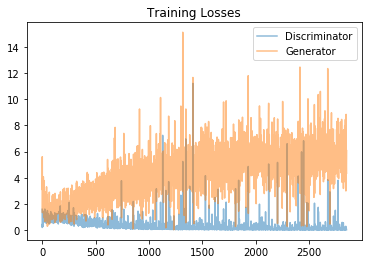

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

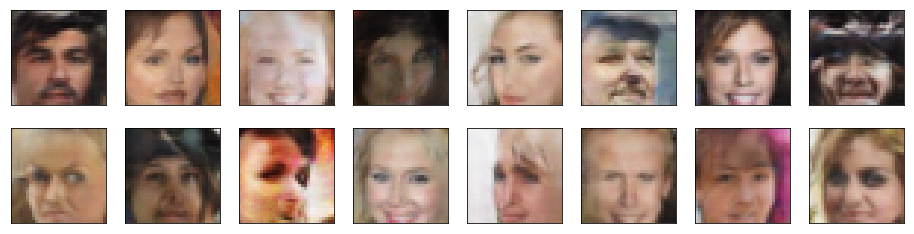

In [28]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
**Dataset**: Most generated faces are white. To make the generated dataset more diverse, the bias of the dataset should be removed by adding more people of color (as well as Asian people etc.).

**Model size**:  The complexity of the generator, as well as the discriminator, could be increased by adding additional convolutional layers. If the model becomes more complex, ResNet units should be used to ease training. By increasing the complexity of the model, I expect both errors to decrease and therefore generate more realistic faces. At the moment, the cost function gets spiky for epochs of about 100 which indicates, that the training becomes unstable for later epochs.

**Optimization strategy**: The optimization parameters seems to be reasonable for this task. A higher number of epochs in combination with a more complex model might help to achieve more realistic final results.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.